In [1]:
import lichess.api
from pprint import pprint
from datetime import datetime
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# working dir should be chessanalytics/src when the notebook starts
while(not os.getcwd().endswith('chess-analytics')):
    os.chdir('..')
print('Working dir: ', os.getcwd())

player_name = 'carequinha'
user = lichess.api.user(player_name)

Working dir:  /home/jorge/GIT/chess-analytics


In [2]:
# %reload_ext autoreload
# %autoreload 2

In [3]:
#from src.get_games import download_games
# download_games(player_name, is_rated=True)
# download games if they don't exist
# games = load_games('resources/PGN_database')

In [5]:
from src.chess_utils.game import ChessGame
games = ChessGame.load_pgn_file('resources/'+ player_name +'.pgn')

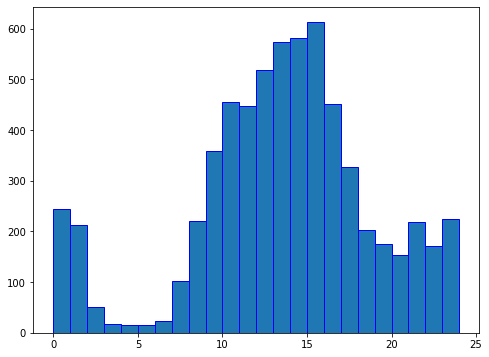

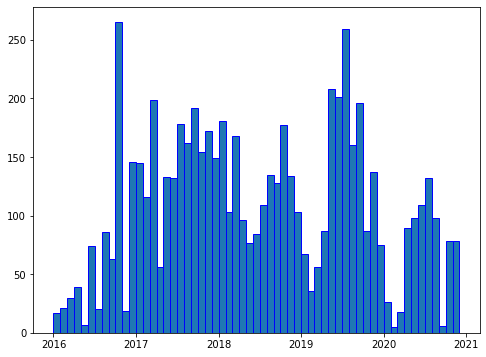

In [6]:
def hist_func(games, func):
    data = [func(game) for game in games]
    bins = list(set(data))
    bins.sort()
    bins.append(bins[-1] + (bins[-1] - bins[-2]))
    plt.figure(figsize=(8,6))
    plt.hist(data, bins = bins, edgecolor='blue')
    plt.show()

hist_func(games, lambda game: game.parse_hours())
hist_func(games, lambda game: game.get_month_year())

In [ ]:
import chess
def print_board_at_move(move_list,
                        move_num: int,
                        player: str):
#move_list = (games[1]['moves'].split())
#move_num = 2
#player = 'black'#'white'
    board = chess.Board()
    board.reset()
    if player is 'white' or player is 'w':
        player_move = 0
    elif player is 'black' or player is 'b':
        player_move = 1
    else:
        raise Exception('No proper input for player.')
    for index in range(2*(move_num-1) + player_move):
        move = move_list.pop(0)
        board.push_san(move)
    return board

In [ ]:
board = print_board_at_move(move_list = (games[0].moves), move_num = 1, player = 'b')
board

In [7]:
import datetime
import calendar

def add_months(sourcedate, months = 1):
    month = sourcedate.astype(object).month -1 + months
    year = sourcedate.astype(object).year + month // 12
    month = month%12 + 1
    return np.datetime64(str(year)+'-'+format(month, '02d'))

def dict_to_list(d):
    dictlist = []
    for k, v in d.items():
        temp = [k,v]
        dictlist.append(temp)
    dictlist.sort(key=lambda x: x[0])
    return dictlist

alt_date = add_months(np.datetime64('2020-01-01'),1)
print(alt_date)

di = {1: 3, -1: 0}
print(dict_to_list(di))

2020-02
[[-1, 0], [1, 3]]


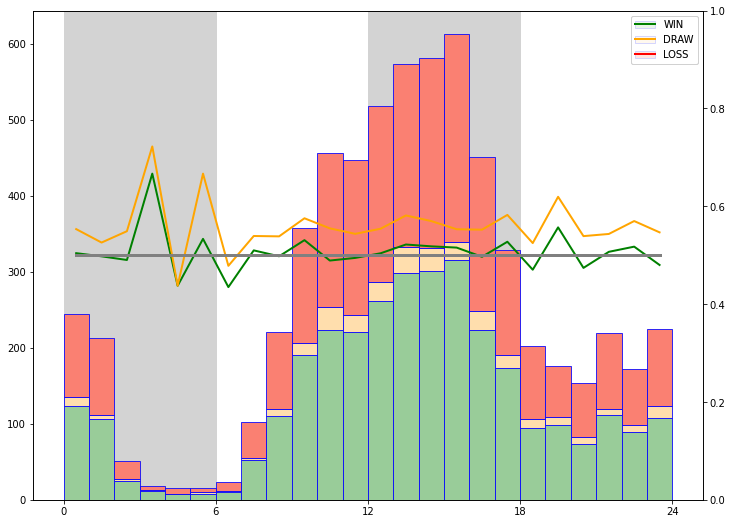

In [10]:
#refactor this to .py
from src.chess_utils.game_etl import array_reshape
from src.chess_utils.game_etl import data_transform_array

bar_colors = {'WIN':[.6,.8,.6],
              'DRAW': 'navajowhite',
              'LOSS': 'salmon'}

line_colors = {'WIN':'green','DRAW': 'orange','LOSS': 'red'}

month = np.timedelta64(1,'M')
year = np.timedelta64(1,'Y')

def partial_accumulation(xy_array):
    domain_dtype = [(xy_array.dtype.names[0],
                     xy_array.dtype[0])]
    d_name = xy_array.dtype.names[0]
    cd_name = xy_array.dtype.names[-1]
    t = 'u4' # 4-bytes integer output
    
    cd_dtype = [(res, t) for res in np.unique(xy_array[cd_name])]
    partial_dtype = domain_dtype + cd_dtype
    
    unique_domain = np.arange(min(xy_array[d_name]),
                          max(xy_array[d_name] + 1))
    partial_results = np.zeros(len(unique_domain),
                               dtype=partial_dtype)
    partial_results[d_name] = unique_domain
    for n, x in enumerate(unique_domain):
        for y in np.unique(xy_array[cd_name]):
            partial_results[n][y] = np.sum((xy_array[d_name ] == x) &
                                           (xy_array[cd_name] == y))

    return partial_results


def background_zones(data, partition):
    unique_domain = np.arange(min(data['X']),
                              max(data['X'] + 1))
    grey_zones = np.unique(unique_domain[::partition])
    grey_zones = np.hstack((grey_zones,
                            max(grey_zones)+partition))
    grey_zones = array_reshape(grey_zones, 2)
    grey_zones = grey_zones.reshape((-1,2))
    for grey_start, grey_finish in grey_zones:
        plt.axvspan(grey_start, grey_finish, color = 'lightgrey')
    return None

def plot_bars(plotable_data):
    bottom = np.zeros(len(plotable_data))

    for k in bar_colors.keys():
        x = plotable_data['X']
        y = plotable_data[k]
        plt.bar(x, y , label=k,
                width=1,
                bottom=bottom,
                color=bar_colors[k],
                align='edge',
                edgecolor='blue',
                linewidth=0.8)
        bottom += y

    plt.legend()
    return None

def plot_lines(plotable):
    plt.ylim(top=1)
    for k in line_colors.keys():
        x = plotable['X'] + 0.5
        y = plotable[k]
        plt.plot(x, y , label=k,
                color=line_colors[k],
                linewidth=2)
        
    plt.plot(x, [0.5]*len(x), color='grey', linewidth=3)

    plt.legend()
    return None

game_results = data_transform_array(games,
                                    [lambda x: x.parse_hours(),
                                     lambda x: x.get_result(player_name)])

plotable = partial_accumulation(game_results)

dtype = [(plotable.dtype.names[0], plotable.dtype[0])] + [(name, 'f8') for name in plotable.dtype.names[1:]]
fraction = np.array(plotable, dtype=dtype, copy=True)
sum = np.zeros(len(fraction))
for n in fraction.dtype.names[1:]:
    sum = np.add(sum, fraction[n])

for index, n in enumerate(bar_colors.keys()):
    fraction[n] = np.true_divide(fraction[n], sum.astype(np.float64))
    for i,k in enumerate(bar_colors.keys()):
        if i < index:
            fraction[n] = np.add(fraction[n], fraction[k])

plt.figure(figsize=(12,9))
split_background = 6
background_zones(plotable, split_background)
plt.xticks(np.arange(0,25,6))

plot_bars(plotable)
ax = plt.twinx()
plot_lines(fraction)
#ax.plot(x,y)
plt.show()

In [12]:
import sys
get_rating = lambda x: int(x.players['white'].rating) if x.players['white'] == player_name else int(x.players['black'].rating)
transformed_data = data_transform_array(games,
                                        [get_rating,
                                         lambda x: x.get_rating_diff(player_name),
                                         lambda x: x.get_result(player_name)])

def discretize(elo, box_list):
    for e in box_list:
        minimum, maximum = e
        if elo >= minimum and elo < maximum:
            return str(minimum)+'-'+str(maximum)
    raise Warning('No set found.')

#def bin(data, box_list):
    

step = 50
minimum = 1850
r = range(minimum , minimum + 5*step, step)
boxed_domain = [[a, a+step] for a in r]
boxed_domain.insert(0, [0, min(r)])
boxed_domain.append([max(r), sys.maxsize])
partial = np.zeros(len(boxed_domain))
sorted_data = np.sort(transformed_data)


game = games[0]
elo = game.players['white'].rating if game.players['white'].name == player_name else game.players['black'].rating
print(discretize(int(elo), boxed_domain))
print(list(boxed_domain))

1950-2000
[[0, 1850], [1850, 1900], [1900, 1950], [1950, 2000], [2000, 2050], [2050, 2100], [2050, 9223372036854775807]]


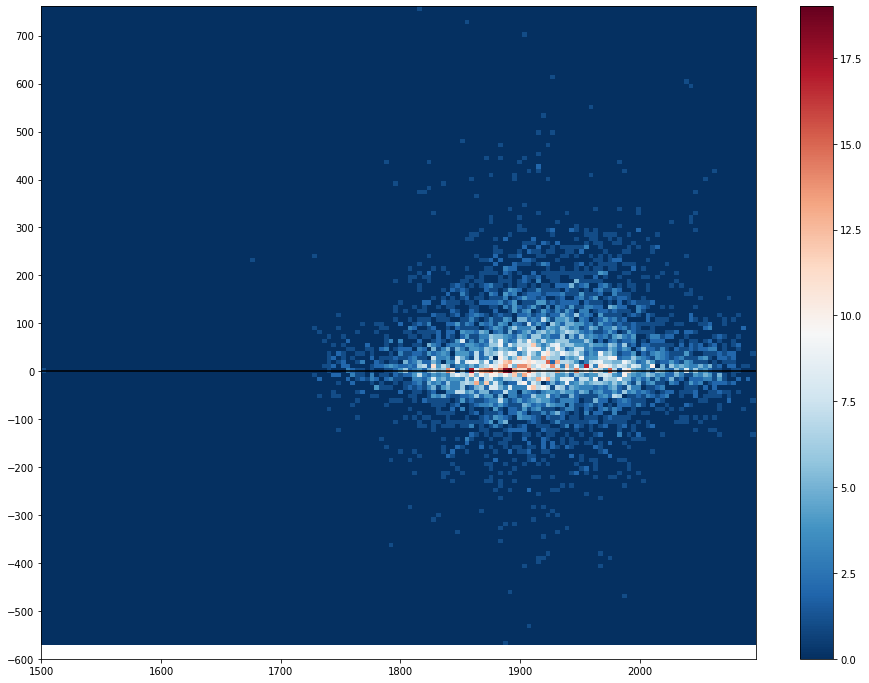

In [17]:
import matplotlib.colors as mcolors
from src.chess_utils.game_etl import data_transform_array

def score_result(game, player):
    # [player_color, opponent_color] = ['white','black'] if game.players['white'].name == player else ['black', 'white']
    return [int(game.get_player_rating(player)), int(game.get_rating_diff(player)), game.get_result(player)]

bar_colors = {'WIN': 'Greens',
              'DRAW': 'Oranges',
              'LOSS': 'Reds'}

data = list(map(lambda game: score_result(game, player_name), games))
array_data = data_transform_array(games,
                                    [lambda x: score_result(x, player_name)[0],
                                     lambda x: score_result(x, player_name)[1],
                                     lambda x: score_result(x, player_name)[2]],
                                 arg_labels = ['p_elo','op_elo','result'])

def array_ticks(array, arg, delta):
    return np.arange(round(min(array[arg]),-2),round(max(array[arg]),-2),delta)

delta = 100
x = np.arange(round(min(array_data['p_elo']),-2),round(max(array_data['p_elo'])+delta,-2),delta)

plt.figure(figsize=(16,12))
for k,v in bar_colors.items():
    p_data = array_data
    p_data = array_data[array_data['result'] == k]
    plt.hist2d(p_data['p_elo'], p_data['op_elo'], bins=30, cmap=v)

plt.hist2d(array_data['p_elo'], array_data['op_elo'], bins=150, cmap='RdBu_r')

plt.colorbar()
plt.xticks(array_ticks(array_data,'p_elo',delta))
plt.yticks(array_ticks(array_data,'op_elo',delta))

plt.plot(x,np.zeros(len(x)),color='black')
plt.show()

In [18]:
count_dict = count(lambda game: game.eco, games)
arg = {k:v for k, v in sorted(count_dict.items(), key = lambda item:item[1], reverse=True)}
for k,v in arg.items():
    print(k,v)

NameError: name 'count' is not defined